In [1]:
get_ipython().run_line_magic('matplotlib','notebook')
# get_ipython().run_line_magic('matplotlib','inline')
get_ipython().run_line_magic('load_ext','autoreload')
get_ipython().run_line_magic('autoreload', '2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

/albedo/home/pscholz/tripyview/tripyview/sub_data.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


/albedo/home/pscholz/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [3]:
# Parameters
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_norim/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_pengyang_cavity_core2/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
vname     = ''
year      = [1979, 2019]
mon, day, record, box, depth = None, None, None, None, 1000
box       = [-180, 180, -90, -65]
#_____________________________________________________________________________________
cstr, cnum = 'blue2red', 20
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
proj, box         = 'sps', [-180, 180, -90, -60]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=False, do_cavity=True, do_loadraw=True)

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)


 > load mesh from *.out files: /albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test
 > comp e_area
 > comp n_area
 > compute lsmask
 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test/tripyview_fesom2_help_macaspel_rglobi_117test_pbnd.shp
 > augment lsmask


/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test/tripyview_fesom2_help_macaspel_rglobi_117test_focus=0.shp
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test
 > id              = help_macaspel_rglobi_117test
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = True
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 1074800
 > #elem           = 2115935
 > #lvls           = 117
___________________________________________


/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


## <ins> Load/Plot cavity elemental vertical boundary index <ins>
In the model corresponds to the variable ulevels(elem)    
- load cavity boundary index on elements before the constrains (elemental ocean prisms are not allowed to have three boundary nodes, <br>
  there must be always at least three valid ocean layers, no isolated nodes are allowed in the vertical) are imposed e_ic_raw (cavity_elvls_raw.out)
- load cavity boundary index on elements after the constrains are imposed e_ic (cavity_elvls.out)    

In [5]:
# load e_ic_raw
datac0 = xr.Dataset(data_vars=dict(e_i=(['elem'], mesh.e_ic_raw.astype('float32'), dict({'descript':'e_ic_raw', 'long_name':'raw cav. elem idx', 'units':''}))),
                 coords=dict(elem=('elem', np.arange(0,mesh.n2de)))).chunk(chunks={'elem':'auto'})
datac0, dum, dum = tpv.do_gridinfo_and_weights(mesh,datac0,do_zweight=False)
datac0 = datac0.assign_attrs({'proj':proj})

# load e_ic
datac1 = xr.Dataset(data_vars=dict(e_i=(['elem'], mesh.e_ic.astype('float32'), dict({'descript':'e_ic', 'long_name':'cav. elem idx', 'units':''}))),
                 coords=dict(elem=('elem', np.arange(0,mesh.n2de)))).chunk(chunks={'elem':'auto'})
datac1, dum, dum = tpv.do_gridinfo_and_weights(mesh,datac1,do_zweight=False)
datac1 = datac1.assign_attrs({'proj':proj})

# load e_ic - e_ic_raw
datac10 = tpv.do_anomaly(datac1, datac0)
# datac10.e_i[datac10.e_i==0]=np.nan

{'cstr': 'wbgyr', 'cnum': 20, 'chist': False, 'ctresh': 0.995, 'cmin': 0, 'cmax': np.float32(81.0)}


<IPython.core.display.Javascript object>


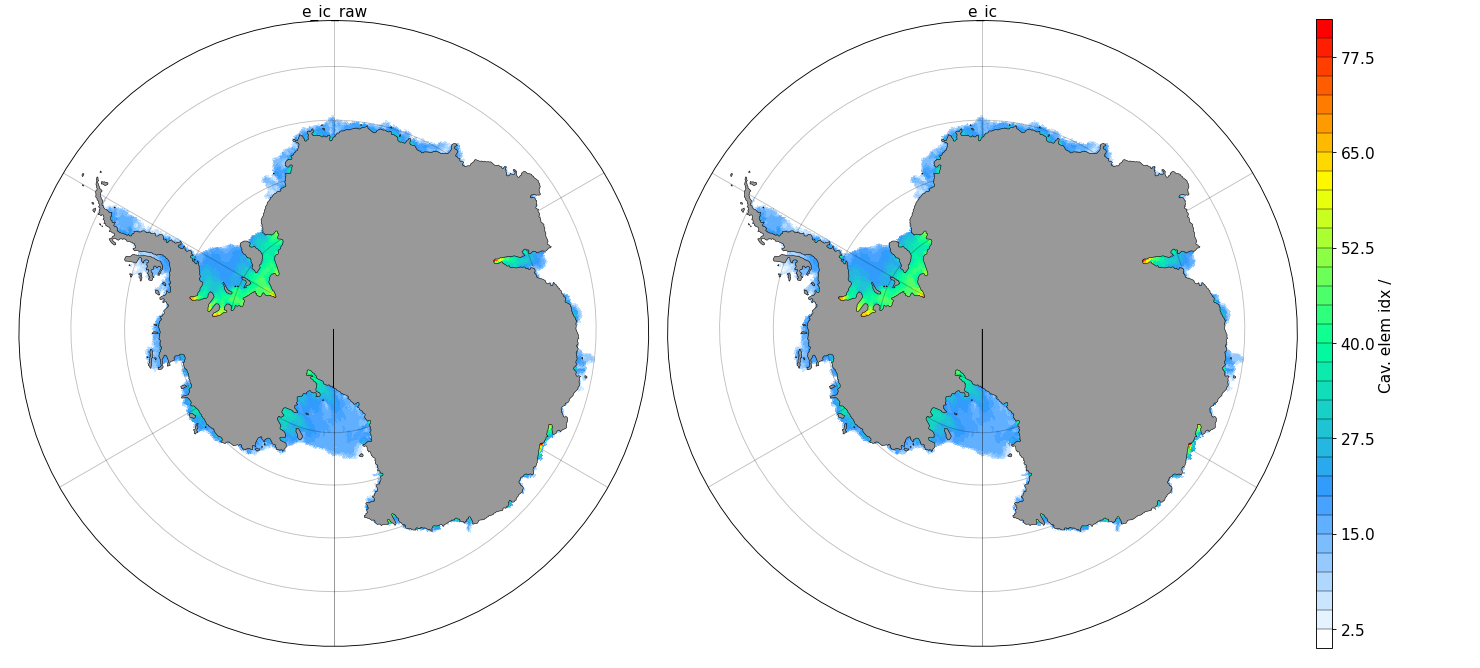

/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


{'cstr': 'wbgyr', 'cnum': 20, 'chist': False, 'ctresh': 0.995, 'cmin': 0, 'cmax': np.float32(81.0), 'cnlab': 8, 'cref': np.float32(40.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x7fa844404d30>, 'clevel': array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
       27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5,
       55. , 57.5, 60. , 62.5, 65. , 67.5, 70. , 72.5, 75. , 77.5, 80. ,
       82.5]), 'clab': array([ 2.5, 15. , 27.5, 40. , 52.5, 65. , 77.5])}


<IPython.core.display.Javascript object>


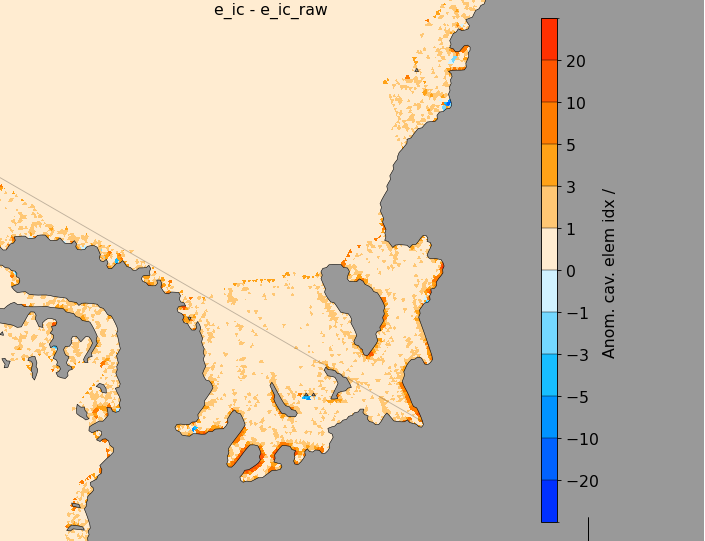

/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


--> cmin/cmax: fin: -41.000000/27.000000
[-40 -20 -10  -5  -3  -1   0   1   3   5  10  20  40] 0
{'cstr': 'blue2red', 'cnum': 20, 'chist': False, 'ctresh': 0.995, 'cref': np.int64(0), 'cnlab': 8, 'cmin': np.float64(-41.0), 'cmax': np.float64(27.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x7fa8446a6970>, 'clevel': array([-40, -20, -10,  -5,  -3,  -1,   0,   1,   3,   5,  10,  20,  40]), 'clab': array([-20, -10,  -5,  -3,  -1,   0,   1,   3,   5,  10,  20])}


In [7]:
#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
svname = list(datac0.data_vars)[0]
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}.{:s}'.format(svname, proj, sfmt)) )

cinfo0 = cinfo.copy()        
cinfo0.update({'cstr':'wbgyr', 'cmin':0, 'cmax':datac0[svname].data.max().compute(), 'chist':False})
print(cinfo0)
fig, ax, cbar = tpv.plot_hslice(mesh, [datac0, datac1], cinfo=cinfo0, box=box, nrow=1, ncol=2, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':5.0, 'cb_plt':True, 'cb_plt_single':True, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sfpath = None
svname = list(datac10.data_vars)[0]
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_diff_{:s}.{:s}'.format('svname', proj, sfmt)) )

cinfo0 = cinfo.copy()        
cinfo0.update({'cstr':'blue2red', 'cref':0, 'chist':False})
do_rescale0 = np.hstack([-40,-20,-10,-5,-3,-1,0,1,3,5,10,20,40])
# cinfo0.update({'cstr':'blue2red', 'cmin':datac10[svname].data.min().compute(), 'cmax':datac10[svname].data.max().compute(), 'cref':0, 'cstep':1, 'chist':False})
fig, ax, cbar = tpv.plot_hslice(mesh, [datac10], cinfo=cinfo0, box=box, nrow=1, ncol=1, proj=proj, do_rescale=do_rescale0,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':4.0, 'cb_plt':True, 'cb_plt_single':True, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

## <ins> Load/Plot bottom elemental vertical boundary index <ins>
- load bottom boundary index on elements before the constrains (elemental ocean prisms are not <br> 
  allowed to have three boundary nodes) are imposed e_iz_raw (elvls_raw.out)
- load bottom boundary index on elements after the constrains are imposed e_iz (elvls.out)    

In [9]:
# load e_iz_raw
dataz0 = xr.Dataset(data_vars=dict(e_i=(['elem'], mesh.e_iz_raw.astype('float32'), dict({'descript':'e_iz_raw', 'long_name':'raw bottom elem idx', 'units':''}))),
                 coords=dict(elem=('elem', np.arange(0,mesh.n2de)))).chunk(chunks={'elem':1e4})
dataz0, dum, dum = tpv.do_gridinfo_and_weights(mesh,dataz0,do_zweight=False)
dataz0 = dataz0.assign_attrs({'proj':proj})

# load e_iz
dataz1 = xr.Dataset(data_vars=dict(e_i=(['elem'], mesh.e_iz.astype('float32'), dict({'descript':'e_iz', 'long_name':'bottom elem idx', 'units':''}))),
                 coords=dict(elem=('elem', np.arange(0,mesh.n2de)))).chunk(chunks={'elem':1e4})
dataz1, dum, dum = tpv.do_gridinfo_and_weights(mesh,dataz1,do_zweight=False)
dataz1 = dataz1.assign_attrs({'proj':proj})

# load e_iz - e_iz_raw
dataz10 = tpv.do_anomaly(dataz1, dataz0)

<IPython.core.display.Javascript object>


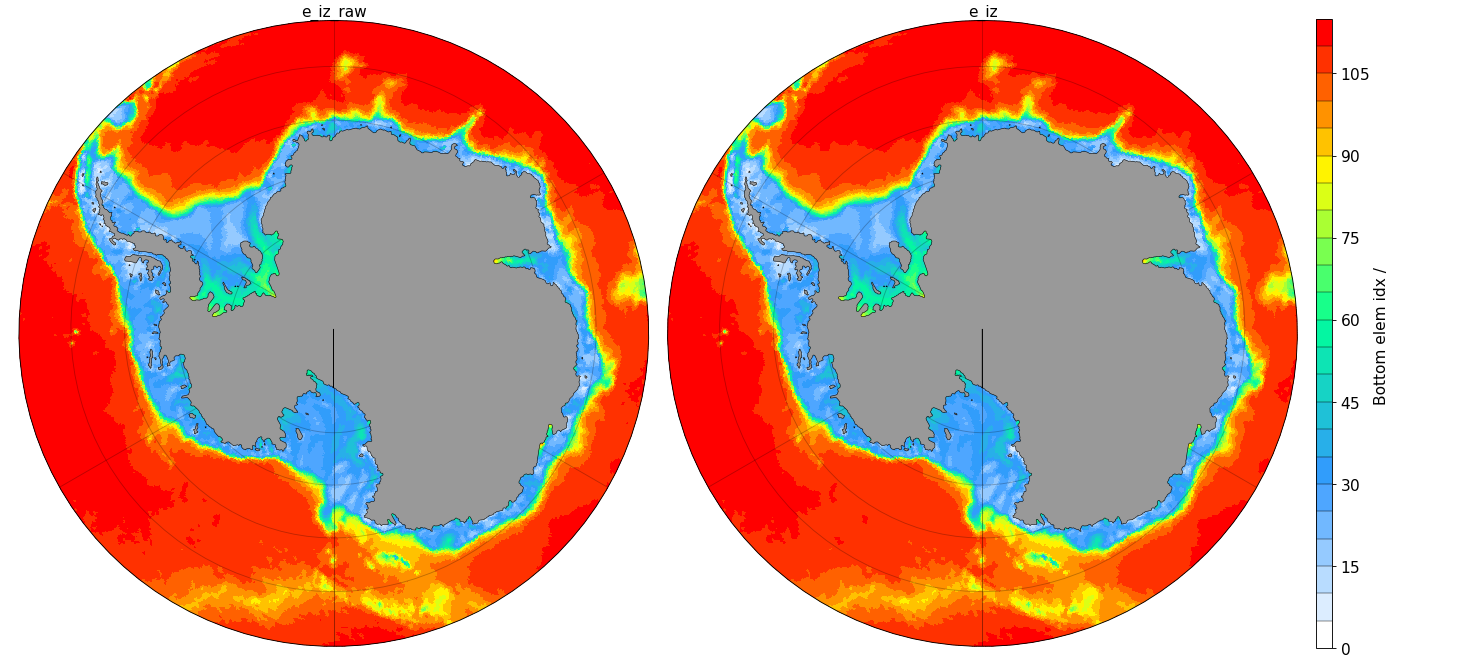

/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


{'cstr': 'wbgyr', 'cnum': 20, 'chist': False, 'ctresh': 0.995, 'cmin': 0, 'cmax': np.float32(115.0), 'cnlab': 8, 'cref': np.float32(60.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x7fa819840f40>, 'clevel': array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115.]), 'clab': array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105.])}


<IPython.core.display.Javascript object>


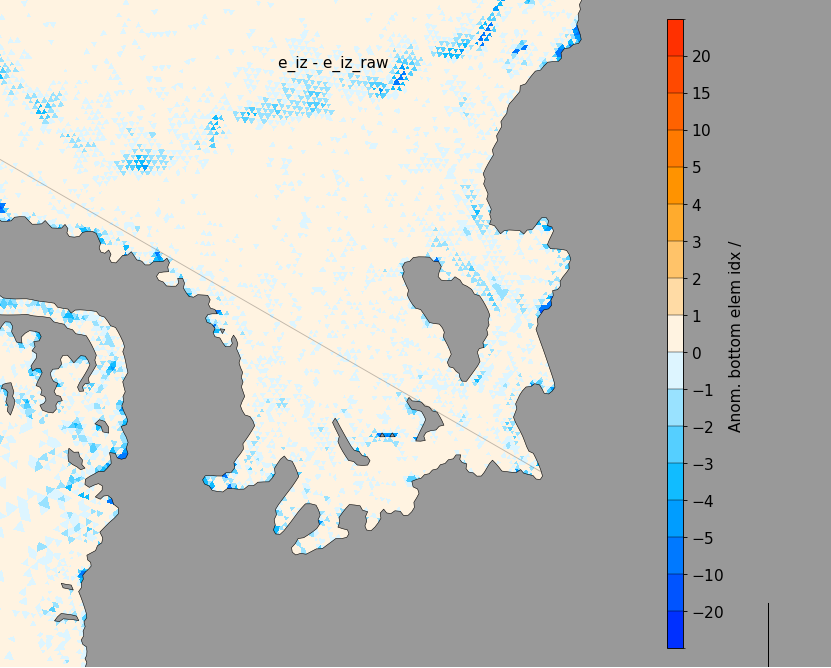

/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


[-30 -20 -10  -5  -4  -3  -2  -1   0   1   2   3   4   5  10  15  20  30] 0
{'cstr': 'blue2red', 'cnum': 20, 'chist': False, 'ctresh': 0.995, 'cmin': np.float32(-26.0), 'cmax': np.float32(0.0), 'cref': np.int64(0), 'cnlab': 8, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fa524876a30>, 'clevel': array([-30, -20, -10,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
         5,  10,  15,  20,  30]), 'clab': array([-20, -10,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
        10,  15,  20])}


In [10]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
svname = list(dataz0.data_vars)[0]
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}.{:s}'.format(svname, proj, sfmt)) )

cinfo0 = cinfo.copy()        
cinfo0.update({'cstr':'wbgyr', 'cmin':0, 'cmax':dataz0[svname].data.max().compute(), 'chist':False})
fig, ax, cbar = tpv.plot_hslice(mesh, [dataz0, dataz1], cinfo=cinfo0, box=box, nrow=1, ncol=2, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':5.0, 'cb_plt':True, 'cb_plt_single':True, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sfpath = None
svname = list(dataz10.data_vars)[0]
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_diff_{:s}.{:s}'.format('svname', proj, sfmt)) )

cinfo0 = cinfo.copy()        
cinfo0.update({'cstr':'blue2red', 'cmin':dataz10[svname].data.min().compute(), 'cmax':dataz10[svname].data.max().compute(), 'cref':0,'chist':False})
do_rescale0 = np.hstack([-30,-20,-10,-5,-4,-3,-2,-1,0,1,2,3,4,5,10,15,20,30])
fig, ax, cbar = tpv.plot_hslice(mesh, [dataz10], cinfo=cinfo0, box=box, nrow=1, ncol=1, proj=proj, do_rescale=do_rescale0,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':5.0, 'cb_plt':True, 'cb_plt_single':True, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  